![MOSEK ApS](https://mosek.com/files/mosek_logo_color.png )

Smallest sphere enclosing a set of points.
===========================

The aim of this tutorial is two-fold

1. Demostrate how to write a conic quadratic model in `Fusion` in a very simple and compact way.
2. Show how and way the dual formulation may solved more efficiently.


Our problem is the defined as:

**Find the smallest sphere that encloses a set of** $k$ **points** $p_i \in \mathbb{R}^n$. 

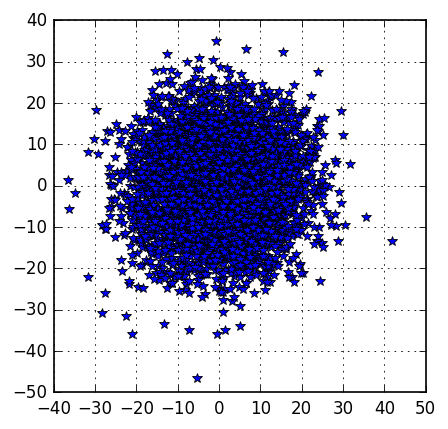

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import random

def plot_points(p, p0=[], r0=0.):
    n,k= len(p0), len(p)
    
    plt.rc('savefig',dpi=120)

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.plot([ p[i][0] for i in range(k)], [ p[i][1] for i in range(k)], 'b*')
    
    if len(p0)>0:
        ax.plot(  p0[0],p0[1], 'r.')
        ax.add_patch( mpatches.Circle( p0,  r0 ,  fc="w", ec="r", lw=1.5) )
    plt.grid()
    plt.show()

n = 2
k = 5000

p=  [ [random.gauss(0.,10.) for nn in range(n)] for kk in range(k)]

plot_points(p)

The problem boils down to determine the sphere center $p_0\in \mathbb{R}^n$ and its radius $r_0\geq 0$, i.e.


\begin{equation}
  \begin{aligned}
\min \max_{i=1,\dots,k} \| p_0 - p_i\|_2 \\
  \end{aligned}
\end{equation}

The maximum in the objective function can be easily, i.e.

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& r_0 \geq \| p_0 - p_i\|_2 ,& \quad & i=1,\ldots,k\\
\end{aligned}
\end{equation}

The SOCP formulation reads

\begin{equation}
  \begin{aligned}
\min r_0 & & &\\
s.t.& & &\\
& \left[r_0,p_0 - p_i\right] \in Q^{(n+1)}, & \quad & i=1,\ldots,k.
\end{aligned}
\end{equation}

Before defining the constraints, we note that we can write


\begin{equation}
R_0 = \left( \begin{array}{c} r_0   \\ \vdots \\ r_0   \end{array} \right) \in \mathbb{R}^k          , \quad
P_0 = \left( \begin{array}{c} p_0^T \\ \vdots \\ p_0^T \end{array} \right) \in \mathbb{R}^{k\times n}, \quad
P   = \left( \begin{array}{c} p_1^T \\ \vdots \\ p_k^T \end{array} \right) \in \mathbb{R}^{k\times n}.
\end{equation}

so that 

\begin{equation}
\left[r_0,p_i - p_0\right] \in Q^{(n+1)},  \quad  i=1,\ldots,k.
\end{equation}

can be compactly expressed as 

\begin{equation}
\left[ R_0,P_0-P\right] \in \Pi Q^{(n+1)},
\end{equation}

that means, with a little abuse of notation, that each rows belongs to a quadratic cone of dimension $n+1$.


Now we are ready for a compact implementation in `Fusion`:

In [19]:
from mosek.fusion import *
import mosek as msk


def primal_problem(P):

    print(msk.Env.getversion())
    
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - primal") as M:

        r0 = M.variable(1         , Domain.greaterThan(0.))
        p0 = M.variable(NDSet(1,n), Domain.unbounded())

        R0 = Var.repeat(r0,k)
        P0 = Var.repeat(p0,k)
       
        M.constraint( Expr.hstack( R0, Expr.sub( P0 , Matrix.dense(P) ) ), Domain.inQCone())

        M.objective(ObjectiveSense.Minimize, r0)
        M.setLogHandler(open('logp','wt'))

        M.solve()

        return r0.level()[0], p0.level()
           

We will also store the solver output in a file to use it later on. And then just solve the problem.

In [20]:
r0,p0 = primal_problem(p)

print ("r0^* = ", r0)
print ("p0^* = ", p0)

(8, 0, 0, 31)
r0^* =  41.0589602489
p0^* =  [ 1.34658816 -5.94970648]


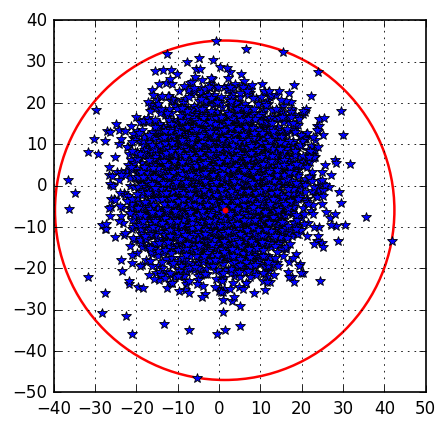

In [21]:
plot_points(p,p0,r0)

Dual Formulation 
-----------------------

The dual problem can be determined in few steps following basic rules. Introducing dual variables

\begin{equation}
 Y = \left( \begin{array}{c} y_1^T\\ \vdots \\y_k  \end{array}\right), \quad z = \left( \begin{array}{c} z_1\\ \vdots \\z_k  \end{array}\right), 
\end{equation}

the dual is:

\begin{aligned}
    \max & \left\langle P, Y \right\rangle \\
    & e_k^T z = 1\\
    & Y^T e_k = \mathbf{0}_n \\
    & \left[z_i , y_i\right] \in \mathcal{Q}^{n+1}\\
    & z_i\in \mathbb{R}, y_i\in \mathbb{R}^n,
\end{aligned}

where $e_k\in \mathbb{R}^k$ is a vector of all ones.

The ``Fusion`` code is the following:


In [26]:
def dual_problem(P):
        
    k= len(P)
    if k==0: return -1,[]

    n= len(P[0])
    
    with Model("minimal sphere enclosing a set of points - dual") as M:
  
        Y= M.variable([k,n], Domain.unbounded())
        z= M.variable(k         , Domain.unbounded())
                    
        M.constraint(Expr.sum(z), Domain.equalsTo(1.) )
        
        e= [1.0 for i in range(k)]
        
        M.constraint(Expr.mul(Y.transpose(), Matrix.ones(k,1)), Domain.equalsTo(0.) )

        M.constraint( Var.hstack(z,Y), Domain.inQCone())
        
        M.objective( ObjectiveSense.Maximize, Expr.dot( P, Y )) 
  
        M.setLogHandler(open('logd','wt'))

        M.solve()

    
dual_problem(p)

Let's take a closer look to the solver output:

In [27]:
!tail  logp

10  2.4e-06  1.1e-03  3.9e-06  1.03e+00   4.107330872e+01   4.111893714e+01   2.1e-07  0.10  
11  2.3e-07  9.9e-05  1.2e-06  1.00e+00   4.105999388e+01   4.106427029e+01   2.0e-08  0.10  
12  3.5e-08  1.5e-05  4.8e-07  1.00e+00   4.105901819e+01   4.105964695e+01   3.0e-09  0.11  
13  8.3e-09  3.6e-06  2.6e-07  1.00e+00   4.105896501e+01   4.105908309e+01   7.1e-10  0.11  
14  2.8e-10  1.2e-07  5.6e-08  1.00e+00   4.105896032e+01   4.105896342e+01   2.4e-11  0.12  
15  1.1e-11  4.0e-09  1.4e-08  1.00e+00   4.105896025e+01   4.105896035e+01   8.0e-13  0.12  
16  3.0e-11  2.5e-10  8.9e-07  1.00e+00   4.105896025e+01   4.105896026e+01   4.9e-14  0.12  
Interior-point optimizer terminated. Time: 0.13. 

Optimizer terminated. Time: 0.15    


In [28]:
!tail logd

10  1.1e-03  2.4e-06  3.9e-06  1.03e+00   4.111893799e+01   4.107330895e+01   2.1e-07  0.08  
11  9.9e-05  2.3e-07  1.2e-06  1.00e+00   4.106427039e+01   4.105999390e+01   2.0e-08  0.09  
12  1.5e-05  3.5e-08  4.8e-07  1.00e+00   4.105964696e+01   4.105901820e+01   3.0e-09  0.09  
13  3.6e-06  8.3e-09  2.6e-07  1.00e+00   4.105908310e+01   4.105896501e+01   7.1e-10  0.10  
14  1.2e-07  2.8e-10  5.4e-08  1.00e+00   4.105896342e+01   4.105896032e+01   2.4e-11  0.10  
15  4.0e-09  1.7e-11  1.1e-08  1.00e+00   4.105896035e+01   4.105896025e+01   8.0e-13  0.10  
16  2.5e-10  5.9e-11  5.1e-08  1.00e+00   4.105896026e+01   4.105896025e+01   4.9e-14  0.11  
Interior-point optimizer terminated. Time: 0.11. 

Optimizer terminated. Time: 0.12    


**How do we explain the differences in running time?**

We know that th ecomplexity of solving the primal or dual is the same. What about the dimensions?

Let's look at the solver output again:

In [29]:
!grep Optimizer logp 

Optimizer started.
Optimizer  - threads                : 2               
Optimizer  - solved problem         : the dual        
Optimizer  - Constraints            : 3
Optimizer  - Cones                  : 5000
Optimizer  - Scalar variables       : 15001             conic                  : 15000           
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Optimizer terminated. Time: 0.15    


In [30]:
!grep Optimizer logd

Optimizer started.
Optimizer  - threads                : 2               
Optimizer  - solved problem         : the primal      
Optimizer  - Constraints            : 3
Optimizer  - Cones                  : 5000
Optimizer  - Scalar variables       : 15000             conic                  : 15000           
Optimizer  - Semi-definite variables: 0                 scalarized             : 0               
Optimizer terminated. Time: 0.12    


**Why is the number of variable and constraint is so different from our formulation?**

`Fusion` performs the following transformation:

\begin{equation}
Ax - b \in \mathcal{K} \rightarrow \quad \left\lbrace\begin{array}{ll} y = Ax-b\\ y\in \mathcal{K} \end{array}\right.
\end{equation}

The reason is to ensure that each variable belongs only in one cone. 

**What is then the reason of the different running time?**

* **MOSEK** uses a primal-dual algorithm that solves both primal and dual at the same time,
* therefore internally there is no difference in terms of problem size.

**So why is the dual formulation so much faster?**

The answer comes from a closer inspection to the solver output, in particular the reported `flops`:


In [31]:
!grep flop log* 

logd:Factor     - dense dim.             : 0                 flops                  : 1.00e+05        
logp:Factor     - dense dim.             : 0                 flops                  : 1.00e+05        


In [32]:
!grep flop log* | cut -d':' -f 4 | xargs printf "1/(%f/%f)\n" | bc -l

1.00000000000000000000


In [33]:
!grep "Interior-point optimizer" log* | cut -d':' -f 3| cut -d'.' -f1-2  | xargs printf "1/(%f/%f)\n" | bc -l

1.18181818181818181819


When moving from theory to practical implementation, **MOSEK** is somehow biased towards the primal, i.e. the formulation we input:

* some steps, most notably factorizations, are in practice order dependent,
* it is important to not be mislead by the problem dimension looking only at the number of variables, constraints and cones,
* if performance are a concern, both primal and dual should be tried.

---------------------------------------------------------------------------------------------------------------

The **MOSEK** logo and name are trademarks of Mosek ApS.

The code is provided as-is. Compatibility with future release of **MOSEK** or the `Fusion API` are not guaranteed.

For more information contact [support_at_mosek.com](mailto:support@mosek.com)

---------------------------------------------------------------------------------------------------------------


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">The MOSEK collection of iPython Notebook</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" property="cc:attributionName" rel="cc:attributionURL">MOSEK ApS</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.<br />Based on a work at <a xmlns:dct="http://purl.org/dc/terms/" href="https://github.com/MOSEK" rel="dct:source">https://github.com/MOSEK</a>.<br />Permissions beyond the scope of this license may be available at <a xmlns:cc="http://creativecommons.org/ns#" href="www.mosek.com" rel="cc:morePermissions">www.mosek.com</a>.

In [ ]:
!cat logp | grep Optimizer

In [ ]:
!cat logd | grep Optimizer
